<a href="https://colab.research.google.com/github/victorm0202/OP-2020-code/blob/master/05_Taller_Regularizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Advanced deep-learning best practices

## 04.1 - Monitoreando modelos de Deep Learning usando Keras callbacks y TensorBoard

### 04.1.1 - Callbacks

* **Model checkpointing** : Guarda los pesos actuales del modelo en diferentes puntos del entrenamiento


* **Early stopping**: Interrumpe el entrenamiento cuando el error de validación no mejora (guarda el mejor modelo obtenido en el entrenamiento)


* **Dynamically adjusting the value of certain parameters during training**: Tal como el learning rate del optimizador 


* **Logging training and validation metrics during training, or visualizing the representations
learned by the model as they’re updated** : La barra del progreso de Keras


In [ ]:
import keras
tensorflow.keras.callbacks.ModelCheckpoint
tensorflow.keras.callbacks.EarlyStopping
tensorflow.keras.callbacks.LearningRateScheduler
tensorflow.keras.callbacks.ReduceLROnPlateau
tensorflow.keras.callbacks.CSVLogger

**THE MODELCHECKPOINT AND EARLYSTOPPING CALLBACKS**

* **EarlyStopping callback:** interrumpe el entrenamiento una vez que la metrica a monitorear deja de mejorar para un número fijo de epocas. Permite detener el entrenamiento antes de presentar problemas de overfitting


* **ModelCechpoint**: permite guardr continuamente el modelo durante el entrenamiento (sólo guarda el mejor modelo: el modelo que registra la mejor actuación al final de cada epoca)

In [ ]:
import tensorflow as tf 

# Callback se pasa como argumento en la parte del "fit"
# por medio de objeto lista puede pasar cualquier número de callbacks

callbacks_list = [ tf.keras.callbacks.EarlyStopping( monitor='acc', patience=1,), # Interrumpe entrenamiento cuando no hay mejora
                  
                  # monitor -> Monitorea el accuracy de validación del modelo
                  # patience -> Interrumpe el entrenamiento cuando el accuracy no mejora apartir de una epoca
                  
                  tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True,)] # Saves the current weights after every epoch
                # filepath -> Dirrecchion a guardar del modelo
                # monitor & save_best_only ->  Significan que tu no quieres sobre escribir
                # los modelos solo si el error de validación mejora
                # permitiendo guardar solo los mejores modelos durante el entrenamiento.
        

# Si monitoreas accuracy, debe ser parte de tu metrica
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Note that because the callback will monitor validation loss and validation accuracy, you need to pass validation_data to the call to fit.
model.fit(x, y, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=(x_val, y_val) )

**THE REDUCELRONPLATEAU CALLBACK**

* Reduce el learnig rate cuando el error de validación no mejora. Es una estrategia efectiva para salir de mínimos locales durante el entrenamiento

In [ ]:
callbacks_list = [
tf.keras.callbacks.ReduceLROnPlateau(
monitor='val_loss' # Monitorea el error de validación del modelo
factor=0.1, # Divide la tasa de aprendizaje por 10 cuando se activa
patience=10, # El callback se activa a partir de que el error de validación deja de 
            # mejorar durante 10 epocas
)
]


model.fit(x, y,
epochs=10,
batch_size=32,
callbacks=callbacks_list,
validation_data=(x_val, y_val))

**Escribiendo tu propio callback**

* Si requieres de una acción en especifico durante el entrenamiento es conveniente construir tu popio callback

In [ ]:
tf.keras.callbacks.Callback

on_epoch_begin # Called at the start of every epoch
on_epoch_end # Called at the end of every epoch
on_batch_begin # Called right before processing each batch
on_batch_end # Called right after processing each batch
on_train_begin # Called at the start of training
on_train_end # Called at the end of training

* Estos métodos son llamados con un argumento logs, el cual es un diccionario que contiene la información respecto a los lotes previos, epocas, o el registro del entrenamiento

Ejemplo: Guardar las capaz de activación del modelo al final de cada epoca, esto solo para el primer sample del conjunto de validación

In [ ]:
import tensorflow as tf
import numpy as np

class ActivationLogger(tf.keras.callbacks.Callback):
    # Called by the parent model before training, to inform the callback of what model will be calling it
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = tf.keras.models.Model(model.input,layer_outputs)
    # Model instance that returns the activations of every layer    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
            
    validation_sample = self.validation_data[0][0:1] # Obtains the first input sample of the validation data
    activations = self.activations_model.predict(validation_sample)
    f = open('activations_at_epoch_' + str(epoch) + '.npz', 'w') # Saves arrays to disk
    np.savez(f, activations)
    f.close()

## 04.2 - Arquitecturas  avanzadas

### 04.2.1 -  Batch Normalization

Es una capa que normaliza datos incluso si la media y varianza de los datos cambian durante el entrenamiento. Ayuda en mejorar el problema de saturación.

* Muestras diferentes a algo más simmilar

* Generaliza mejor los nuevos datos



normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)

* Se utiliza usualmente seguido de una capa densa o convolucionañ

In [ ]:
conv_model.add(layers.Conv2D(32, 3, activation='relu')) # After a Conv layer
conv_model.add(layers.BatchNormalization())


dense_model.add(layers.Dense(32, activation='relu')) # After a Dense layer
dense_model.add(layers.BatchNormalization())

### 04.2.2 -   DEPTHWISE SEPARABLE CONVOLUTION

* Depthwise

* Pointwise

Genera modelos más ligeros (menos pesos) y más rápidos con mejora en el desempeño.

La capa realiza una convoluciónespacial para cada canal de entrada, de forma independiente, despues realiza un mixing a los canales de salida por medio de un poinwise convolution (un convolution filtes de tamaño $1 x 1$)

In [ ]:
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))

model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))

model.add(layers.SeparableConv2D(128, 3, activation='relu'))

model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))

model.add(layers.SeparableConv2D(128, 3, activation='relu'))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 11, 11, 64)        9408      
__________

Visualización del modelo

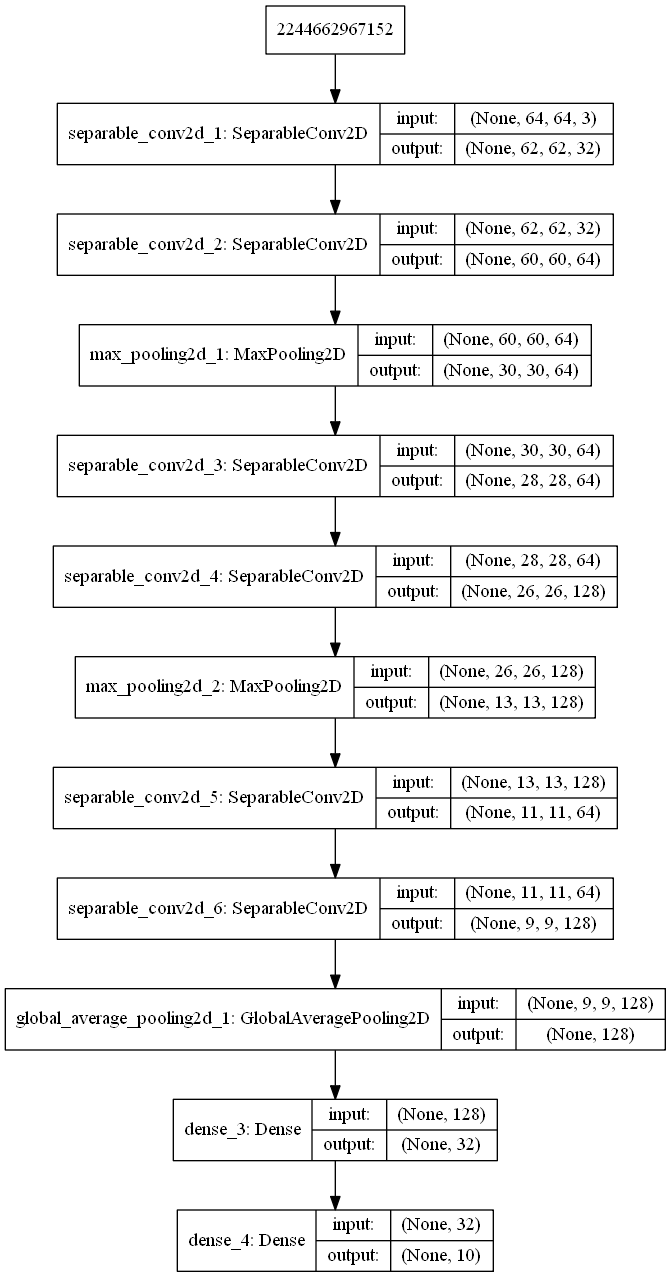

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='deepthwise.png')
from IPython.display import Image
Image(retina=True, filename='deepthwise.png')

## 04.3 -  Optimización de Hyperparametros

Hyperopt (https://github.com/hyperopt/hyperopt)

Hyperas (https://github.com/maxpumperla/hyperas)
integra Hyperopt para utilizar con los modelos de Keras

## 04.4 -  Ensamblado de modelos

Se basa en realiza un pooling de las predicciónde de diferentes modelos, con el fin de mejorar la predicción 

* Trabaja bajo el supuesto de que a diferentes modelos, entrenados de manera diferente, son mejores por distintas razones: cada modelo captira diferencias en la predicción de los datos, obteniendo parte de la verdad en cada uno de ellos.

Una manera de juntar la predicción es; promediando las predicciones.

* Esto solo funciona si los clasificadore son casi igual de buenos

In [ ]:
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)


final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)



Otra manera de ensamblarlos es con un promedio ponderado, donde los pesos se pueden aprender. A mejor el clasificador mayor peso

In [ ]:
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)


final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d

La clave del ensamble es tener clasificadores moderadamente buenos, o buenos, pero que cada uno sea distinto entre si.

### 4.2 Regularización  weight decay L1 (Lasso)  y L2 (Ridge)

* Norma L1

In [ ]:
from tensorflow.keras import regularizers

kernel_regularizer=regularizers.l1(0.001)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(model_input)
x = Dropout(x)(x)
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(x)
model_output = Dense(10, activation ="softmax")(x)

* Norma L2

In [ ]:
from keras import regularizers

kernel_regularizer=regularizers.l2(0.001)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(model_input)
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(x)
model_output = Dense(10, activation ="softmax")(x)

In [ ]:
from keras import regularizers

kernel_regularizer=regularizers.l1_l2(0.001)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l1_l2(0.001), activation = "relu")(model_input)
x = Dense(16, kernel_regularizer=regularizers.l1_l2(0.001), activation = "relu")(x)
model_output = Dense(10, activation ="softmax")(x)

### 4.3 Drop out

In [ ]:
from keras.layers import Dropout

Dropout(.5)

# En el modelo

model_input = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(model_input)
x = Dropout(.5)(x)
x = Dense(16,  activation = "relu")(x)
x = Dropout(.5)(x)
model_output = Dense(10, activation ="softmax")(x)



### Ejercicio 1. Regularización

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### 1.1 - Regularización en los pesos con norma L1

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

l1_model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(l1_model_input)
x = Dense(16, kernel_regularizer=regularizers.l1(0.001), activation = "relu")(x)
l1_model_output = Dense(10, activation ="softmax")(x)

model_l1 = Model(l1_model_input, l1_model_output)

model_l1.summary()


model_l1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])




Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
tic=time.time()

history_l1 = model_l1.fit(train_images, train_labels, epochs=50, batch_size=128, 
                 validation_split=0.2)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3081 - val_accuracy: 0.1060
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3081 - val_accuracy: 0.1060
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3079 - val_accuracy: 0.1060
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3080 - val_accuracy: 0.1060
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3082 - val_accuracy: 0.1060
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3081 - val_accuracy: 0.1060
Epoch 7/50
375/375 [==============================] - 1s 2ms/step - loss: 2.3071 - accuracy: 0.1140 - val_loss: 2.3080 - val_accuracy: 0.1060
Epoch 

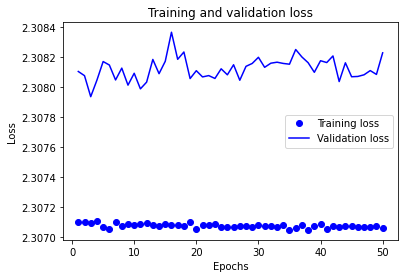

In [ ]:
import matplotlib.pyplot as plt


loss = history_l1.history['loss']
val_loss = history_l1.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_l1.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.5158 - accuracy: 0.9180
test_acc: 0.9179999828338623


### 1.2 - Regularización en los pesos con norma L2

In [ ]:
l2_model_input = Input(shape = (28*28,))
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(l2_model_input)
x = Dense(16, kernel_regularizer=regularizers.l2(0.001), activation = "relu")(x)
l2_model_output = Dense(10, activation ="softmax")(x)

model_l2 = Model(l2_model_input, l2_model_output)

model_l2.summary()


model_l2.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
tic=time.time()

history_l2 = model_l2.fit(train_images, train_labels, epochs=5, batch_size=128, 
                 validation_split=0.2)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

Epoch 1/5
375/375 [==============================] - 1s 3ms/step - loss: 0.7863 - accuracy: 0.7899 - val_loss: 0.4351 - val_accuracy: 0.8985
Epoch 2/5
375/375 [==============================] - 1s 2ms/step - loss: 0.4148 - accuracy: 0.9014 - val_loss: 0.3612 - val_accuracy: 0.9172
Epoch 3/5
375/375 [==============================] - 1s 2ms/step - loss: 0.3624 - accuracy: 0.9166 - val_loss: 0.3443 - val_accuracy: 0.9219
Epoch 4/5
375/375 [==============================] - 1s 2ms/step - loss: 0.3348 - accuracy: 0.9230 - val_loss: 0.3151 - val_accuracy: 0.9313
Epoch 5/5
375/375 [==============================] - 1s 2ms/step - loss: 0.3159 - accuracy: 0.9286 - val_loss: 0.3016 - val_accuracy: 0.9337
Tiempo de procesamiento (secs):  5.498869180679321


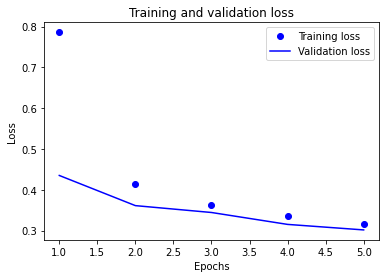

In [ ]:
loss = history_l2.history['loss']
val_loss = history_l2.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_l2.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.3043 - accuracy: 0.9310
test_acc: 0.9309999942779541


### 1.3 Regularización Drop out

In [ ]:
from tensorflow.keras.layers import Dropout

model_dropOut_in = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(model_dropOut_in)
x = Dropout(.5)(x)
x = Dense(16,  activation = "relu")(x)
x = Dropout(.5)(x)
lmodel_dropOut_out = Dense(10, activation ="softmax")(x)

model_dropOut = Model(model_dropOut_in, lmodel_dropOut_out)

model_dropOut.summary()


model_dropOut.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


import time
tic=time.time()

history_dropOut = model_dropOut.fit(train_images, train_labels, epochs=50, batch_size=128, 
                 validation_split=0.2)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                12560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
__________________________________________________

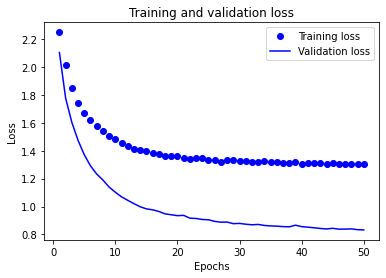

In [ ]:
loss = history_dropOut.history['loss']
val_loss = history_dropOut.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_dropOut.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 899us/step - loss: 0.8500 - accuracy: 0.8024
test_acc: 0.8023999929428101


### 1.4 Callbacks Early stopping

In [ ]:
from tensorflow.keras.layers import Dropout

entrada = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(entrada)
x = Dense(16,  activation = "relu")(x)
salida = Dense(10, activation ="softmax")(x)

modelo = Model(entrada, salida)

modelo.summary()




Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
import tensorflow as tf

callbacks_list = [ tf.keras.callbacks.EarlyStopping( monitor='acc', patience=1,),                 
                  tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True,)] 

modelo.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


tic=time.time()

historia = modelo.fit(train_images, train_labels, epochs=75, batch_size=128, callbacks=callbacks_list, validation_split=0.2 )

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Epoch 1/75
375/375 [==============================] - 1s 3ms/step - loss: 0.3136 - acc: 0.2671 - val_loss: 0.2925 - val_acc: 0.3193
Epoch 2/75
375/375 [==============================] - 1s 2ms/step - loss: 0.2677 - acc: 0.3365 - val_loss: 0.2441 - val_acc: 0.4092
Epoch 3/75
375/375 [==============================] - 1s 2ms/step - loss: 0.2278 - acc: 0.5164 - val_loss: 0.2091 - val_acc: 0.5873
Epoch 4/75
375/375 [==============================] - 1s 2ms/step - loss: 0.1953 - acc: 0.6245 - val_loss: 0.1778 - val_acc: 0.6602
Epoch 5/75
375/375 [==============================] - 1s 2ms/step - loss: 0.1671 - acc: 0.6809 - val_loss: 0.1521 - val_acc: 0.7196
Epoch 6/75
375/375 [==============================] - 1s 2ms/step - loss: 0.1451 - acc: 0.7247 - val_loss: 0.1326 - val_acc: 0.7607
Epoch 7/75
375/375 [==============================] - 1s 2ms/step - loss: 0.1276 - acc: 0.7622 - val_loss: 0.1173 - val_acc: 0.7881
Epoch 8/75
375/375 [==============================] - 1s 2ms/step - loss: 0.

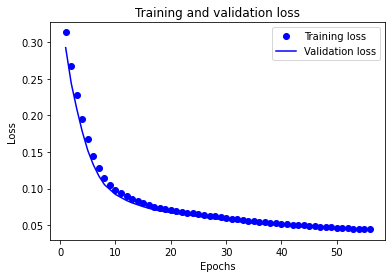

In [ ]:
loss = historia.history['loss']
val_loss = historia.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 869us/step - loss: 0.0452 - acc: 0.9249
test_acc: 0.9248999953269958


* Se observa el número de epoca en el cual se detiene el entrenamiento

In [ ]:
epoca = len(historia.epoch) # epoca seleccionada
print(epoca)

56


* Eliminamos el modelo y entrenamos con el número de epoca obtenida 

In [ ]:
del modelo

In [ ]:
from keras.layers import Dropout

entrada = Input(shape = (28*28,))
x = Dense(16,  activation = "relu")(entrada)
x = Dense(16,  activation = "relu")(x)
salida = Dense(10, activation ="softmax")(x)

modelo = Model(entrada, salida)

modelo.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time

modelo.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


tic=time.time()

historia = modelo.fit(train_images, train_labels, epochs= epoca, batch_size=128, validation_split=0.2 )

print('Tiempo de procesamiento (secs): ', time.time()-tic)

Epoch 1/56
375/375 [==============================] - 1s 2ms/step - loss: 0.3131 - acc: 0.3113 - val_loss: 0.2909 - val_acc: 0.3615
Epoch 2/56
375/375 [==============================] - 1s 2ms/step - loss: 0.2544 - acc: 0.4445 - val_loss: 0.2160 - val_acc: 0.5428
Epoch 3/56
375/375 [==============================] - 1s 2ms/step - loss: 0.1903 - acc: 0.5828 - val_loss: 0.1662 - val_acc: 0.6486
Epoch 4/56
375/375 [==============================] - 1s 2ms/step - loss: 0.1561 - acc: 0.6621 - val_loss: 0.1413 - val_acc: 0.7049
Epoch 5/56
375/375 [==============================] - 1s 2ms/step - loss: 0.1379 - acc: 0.7092 - val_loss: 0.1271 - val_acc: 0.7445
Epoch 6/56
375/375 [==============================] - 1s 2ms/step - loss: 0.1267 - acc: 0.7382 - val_loss: 0.1174 - val_acc: 0.7708
Epoch 7/56
375/375 [==============================] - 1s 2ms/step - loss: 0.1189 - acc: 0.7597 - val_loss: 0.1109 - val_acc: 0.7860
Epoch 8/56
375/375 [==============================] - 1s 2ms/step - loss: 0.

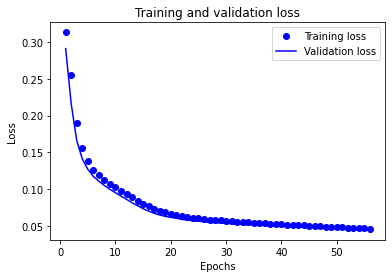

In [ ]:
loss = historia.history['loss']
val_loss = historia.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 907us/step - loss: 0.0465 - acc: 0.9210
test_acc: 0.9210000038146973
